# Co-clustering

## Introduction

This notebook illustrates how to use [Clustering Geo-data Cubes (CGC)](https://cgc.readthedocs.io) to perform a co-clustering analysis of geo-spatial data. 

Co-clustering is a techique that allows to overcome some of the limitations of traditional clustering techniques (like k-means), which operate along a single dimension. For spatio-temporal data, these algorithms allow to identify spatial patterns across the full time span of the data, or, viceversa, temporal patterns for the whole spatial domain considered. With co-clustering, the space and time dimensions can be simultaneously clustered, allowing to create (co-)clusters where individual elements behave similarly in both dimensions. We illustrate how to perform this analysis with CGC using an example phenological dataset representing the day of the year of first bloom.

Note that in addition to CGC, whose installation instructions can be found [here](https://github.com/phenology/cgc), few other packages are required in order to run this notebook. Please have a look at this tutorial's [installation instructions](https://github.com/escience-academy/tutorial-cgc). 

## The data

The data employed in this tutorial is a subset of the first-bloom spring-index calculated for the conterminous US from 1980 to 2015 at 1 km resolution. The data set has been cropped to an area that is (700 km x 700 km) large, approximately corresponding to the State of Washington, and only the last 15 years have been considered. The data is provided as a set of 15 GeoTiff files (one per year, labelled accordingly).
For more information about the data have a look at the original publication https://doi.org/10.1016/j.agrformet.2018.06.028 - please cite this reference if you use the data!

## Imports and general configuration

In [1]:
import cgc
import logging
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from cgc.coclustering import Coclustering
from cgc.kmeans import Kmeans
from dask.distributed import Client

print(f'CGC version: {cgc.__version__}')

CGC version: 0.3.0


CGC makes use of `logging`, set the desired verbosity via:

In [2]:
logging.basicConfig(level=logging.INFO)

## Reading the data

We use `xarray` to read the data, creating a single three-dimensional array (a `DataArray`) that represents the spring index as a function of space (x and y) and time:

In [3]:
years = range(2001, 2016)
spring_index = [xr.open_rasterio(f'../data/{year}.tif') for year in years]
spring_index = xr.concat(spring_index, dim='time')
spring_index = spring_index.squeeze('band', drop=True)  # drop band dimension

# set year as time coordinate
spring_index = spring_index.assign_coords(year=('time', years))

We manipulate the array spatial dimensions creating a combined (x, y) dimension. We also drop all 'pixels' that are null-valued for any of the years considered:

In [4]:
spring_index = spring_index.stack(space=['x', 'y'])
location = np.arange(spring_index.space.size) # create a combined (x,y) index
spring_index = spring_index.assign_coords(location=('space', location))

# drop pixels that are null-valued for any of the time indices
spring_index = spring_index.dropna('space', how='any')  
print(spring_index)

<xarray.DataArray (time: 15, space: 490000)>
array([[130., 130., 130., ...,  60.,  60.,  60.],
       [120., 120., 120., ...,  66.,  66.,  66.],
       [137., 137., 137., ...,  62.,  62.,  62.],
       ...,
       [123., 123., 123., ...,  65.,  65.,  66.],
       [118., 118., 118., ...,  53.,  53.,  53.],
       [109., 110., 110., ...,  57.,  56.,  56.]], dtype=float32)
Coordinates:
    year      (time) int64 2001 2002 2003 2004 2005 ... 2011 2012 2013 2014 2015
  * space     (space) MultiIndex
  - x         (space) float64 -126.3 -126.3 -126.3 ... -120.0 -120.0 -120.0
  - y         (space) float64 49.25 49.24 49.23 49.22 ... 43.0 42.99 42.98 42.97
    location  (space) int64 0 1 2 3 4 5 ... 489995 489996 489997 489998 489999
Dimensions without coordinates: time
Attributes:
    transform:      (0.008983152841195215, 0.0, -126.30312894720473, 0.0, -0....
    crs:            +init=epsg:4326
    res:            (0.008983152841195215, 0.008983152841195215)
    is_tiled:       0
    nodatav

## Co-clustering

### Overview

Starting from a random co-cluster assignment, the algorithm implemented in CGC iteratively updates the co-clusters until the loss function that corresponds to the information loss in each cluster does not significantly change in two consecutive iterations. The solution reached by the algorithm does not necessarily represent the global minimum of the loss function (it might be a local minimum). Thus, multiple differently-initialized runs need to be performed in order to sample the cluster space, and the cluster assignment with the lowest loss-function value selected as best candidate solution. Note that these runs represents embarassingly parallel tasks, and can then be efficiently executed in parallel. For more information about the algorithm, have a look at CGC's co-clustering [documentation](https://cgc.readthedocs.io/en/latest/user_manual.html#co-clustering).

In order to run the co-clustering analysis for the spring index data set, we choose an initial number of spatial and temporal clusters and set the values of few other parameters:

In [5]:
num_time_clusters = 3
num_space_clusters = 5

max_iterations = 10  # maximum number of iterations
conv_threshold = 0.1  # convergence threshold 
nruns = 2  # number of differently-initialized runs

**NOTE**: the number of clusters have been selected in order to keep the memory requirement of the tutorial sufficiently low to run this notebook on [mybinder.org](https://mybinder.org).

We then instantiate a `Coclustering` object:

In [6]:
cc = Coclustering(
    spring_index.data,  # data set (must be a 2D array)
    num_time_clusters,  # number of clusters in the first dimension of the data set (rows)
    num_space_clusters,  # number of clusters in the second dimension of the data set (columns)
    max_iterations=max_iterations,  
    conv_threshold=conv_threshold, 
    nruns=nruns
)

We are now ready to run the analysis. CGC offers multiple implementations of the same co-clustering algorithm, as described in the following subsections. Ultimately, the most suitable implementation for a given problem is dictated by the size of the data set of interest and by the infrastructure that is available for the analysis.

### Numpy-based implementation

A first implementation is based on [Numpy](https://numpy.org) and [threading](https://docs.python.org/3/library/threading.html). It is suitable to run the co-clustering analysis locally, with differently-initialized co-clustering runs being executed in parallel as multiple threads. The `nthreads` argument sets the number of runs simultaneously executed: 

In [7]:
results = cc.run_with_threads(nthreads=1)

INFO:cgc.coclustering:Retrieving run 0
INFO:cgc.coclustering:Error = -2192731648.0
INFO:cgc.coclustering:Retrieving run 1
INFO:cgc.coclustering:Error = -2192730112.0


If multi-core CPUs are available, `nthreads` could be increased up to the value of available cores. Note, however, that the memory requirement also increases for increasing `nthreads`. Also note that the output indicates that convergence is not achieved within 10 iterations. A low value of `max_iterations` is on purpose set here to limit the running time of the tutorial - increasing this value to 100 should lead to converged solutions with the threashold considered.

Calling the method again will perform a new set of co-clustering runs, improving in the sampling of the cluster space:

In [8]:
results = cc.run_with_threads(nthreads=1)

INFO:cgc.coclustering:Retrieving run 2
INFO:cgc.coclustering:Error = -2193805568.0
INFO:cgc.coclustering:Retrieving run 3
INFO:cgc.coclustering:Error = -2193768960.0


### Reducing the memory footprint

The implementation illustrated in the previous section internally exploits vectorized operations between work arrays, whose size increases with both the data set size and the number of row and column clusters. If the data set is relatively large, the memory requirements represent the bottle neck in selecting the number of clusters in the analysis and the number of simultaneous co-clustering runs.

An implementation that significantly reduces the memory footprint of the algorithm, thus bypassing some of these issues, is activated via the `low_memory` argument:

In [9]:
results = cc.run_with_threads(nthreads=1, low_memory=True)

INFO:cgc.coclustering:Retrieving run 4
INFO:cgc.coclustering:Error = -2193980614.6419034
INFO:cgc.coclustering:Retrieving run 5
INFO:cgc.coclustering:Error = -2193970236.3839617


Check out the [memory_profiler](https://github.com/pythonprofilers/memory_profiler) package, in particular the IPython `%memit` magic it implements, to compare the difference in memory usage for the two implementations (it becomes significant only for larger number of clusters).

The reduced memory requirement comes at the cost of performance, since some of the vectorized operations are replaced with (slower) for loops. The performance loss of this low-memory algorithm can be significantly mitigated by activating [Numba](https://numba.pydata.org)’s just-in-time (JIT) compilation for these loops' vectorization, which is employed in CGC when setting the optional argument `numba_jit=True`. Note that the larger the number of clusters, the larger the speedup obtained with Numba JIT compilation.

### Co-clustering with Dask

An alternative implementation makes use of [Dask](https://dask.org) and is thus suitable to run the co-clustering algorithm on distributed systems (e.g. on a cluster of compute nodes). In the implementation illustrated here, Dask arrays are employed to process the data in chunks, with the various tasks being distributed to the workers of the Dask cluster.

Dask arrays can be employed as the underlying structure in a `DataArray`. Data can be read in a chunked fashion or it can be chunked when already in memory, as carried out here via the `chunk` method:

In [10]:
spring_index_da = spring_index.chunk((15, 122500))
print(spring_index_da.data)

dask.array<xarray-<this-array>, shape=(15, 490000), dtype=float32, chunksize=(15, 122500), chunktype=numpy.ndarray>


In [11]:
cc_da = Coclustering(
    spring_index_da.data,
    num_time_clusters,
    num_space_clusters,  
    max_iterations=max_iterations,  
    conv_threshold=conv_threshold, 
    nruns=nruns
)

For the purpose of this tutorial, we make use of a local Dask cluster, which is the default cluster that is created when a `Client` object is initialized without arguments:

In [12]:
client = Client()
print(client)

<Client: 'tcp://127.0.0.1:58517' processes=4 threads=8, memory=16.00 GiB>


Other types of Dask clusters, running e.g. on cloud or HPC systems, can be equivalently employed by specifying the Dask scheduler address when initializing the `Client`. Further information on how to setup a Dask cluster can be found in the [Dask documentation](https://docs.dask.org). 

To start the co-clustering runs, we now pass the instance of the `Client` to the `run_with_dask` method of the `Coclustering` object:

In [13]:
results = cc_da.run_with_dask(client=client, low_memory=True)

INFO:cgc.coclustering:Run 0
INFO:cgc.coclustering:Error = -2193975027.6943283
INFO:cgc.coclustering:Run 1
INFO:cgc.coclustering:Error = -2193957635.1502295


When the runs are finished, we can close the connection with the cluster:

In [14]:
client.close()

### Inspecting the results 

The objects returned by the `run_with_threads` and `run_with_dask` methods contain all the co-clustering results, the most relevant being the row (temporal) and column (spatial) cluster assignments:

In [15]:
print(f"Row (time) clusters: {results.row_clusters}")
print(f"Column (space) clusters: {results.col_clusters}")

Row (time) clusters: [0 1 2 1 0 2 1 0 2 0 1 1 1 2 2]
Column (space) clusters: [0 0 0 ... 2 2 2]


The integers contained in these arrays represent the cluster labels for the two dimensions. They allow to identify the co-cluster to which each element belongs: the (i, j) element of the spring index matrix belongs to the co-cluster (m, n), where m and n are the i-th element of `results.row_clusters` and j-th element of `results.col_clusters`, respectively. 

These arrays can be used to reorder the original spring index data set on the basis of the similarity between its elements. We first create `DataArray`'s for the spatial and temporal clusters: 

In [16]:
time_clusters = xr.DataArray(results.row_clusters, dims='time', 
                             coords=spring_index.time.coords, 
                             name='time cluster')
space_clusters = xr.DataArray(results.col_clusters, dims='space', 
                              coords=spring_index.space.coords, 
                              name='space cluster')

We then include these as coordinates in the data set, and sort its dimensions on the basis of the cluster values:

In [17]:
spring_index = spring_index.assign_coords(time_clusters=time_clusters, 
                                          space_clusters=space_clusters)
spring_index_sorted = spring_index.sortby(['time_clusters', 
                                           'space_clusters'])

Plotting the sorted data set as a function of space and time allows to visualize the co-clusters, which appear as 'blocks' in the matrix representation:

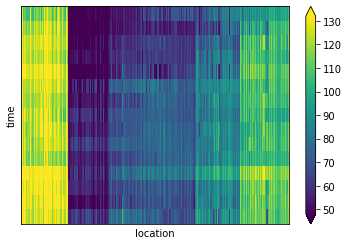

In [18]:
# set colorbar range to cover 90% of the data 
vmin = spring_index.quantile(0.05)
vmax = spring_index.quantile(0.95)

spring_index_sorted.plot.imshow(
    x='location', y='time',
    xticks=[], yticks=[],  # drop tick labels 
    vmin=vmin, vmax=vmax
)

Each block of the matrix can be identified as a spatial region with similar spring index value over a sub set of years. 

The average spring index value for each co-cluster can be computed and plotted in the following way:

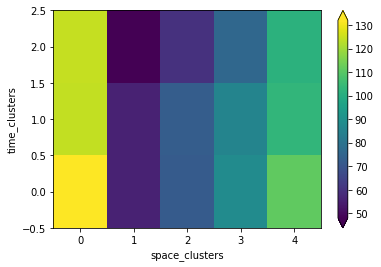

In [19]:
spring_index_vs_clusters = spring_index.set_index(
    {'time': 'time_clusters', 'space': 'space_clusters'}
)
stacked = spring_index_vs_clusters.stack(clusters=('time', 'space'))
means = stacked.groupby('clusters').mean().unstack('clusters')
means = means.rename({'clusters_level_0': 'time_clusters', 
                      'clusters_level_1': 'space_clusters'})
means.plot.imshow(vmin=vmin, vmax=vmax)

We can now visualize the temporal clusters to which each year belongs, and make a histogram of the number of years in each cluster:

(array([4., 6., 5.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

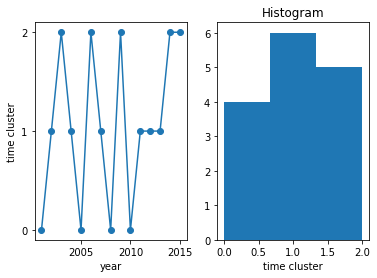

In [20]:
fig, ax = plt.subplots(1, 2)

# line plot
time_clusters.plot(ax=ax[0], x='year', marker='o')
ax[0].set_yticks(range(num_time_clusters))

# temporal cluster histogram
time_clusters.plot.hist(ax=ax[1], bins=num_time_clusters)

Spatial clusters can also be visualized after 'unstacking' the location index that we have initially created, thus reverting to the original (x, y) coordinates:

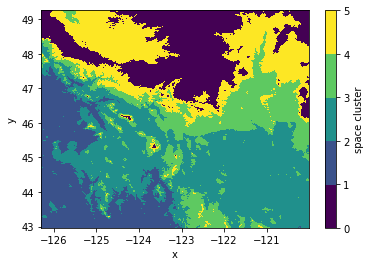

In [21]:
space_clusters_xy = space_clusters.unstack('space')
space_clusters_xy.plot.imshow(x='x', y='y', levels=range(num_space_clusters+1))

The computed co-cluster means and the spatial clusters can be employed to plot the average spring-index value for each of the temporal clusters: 

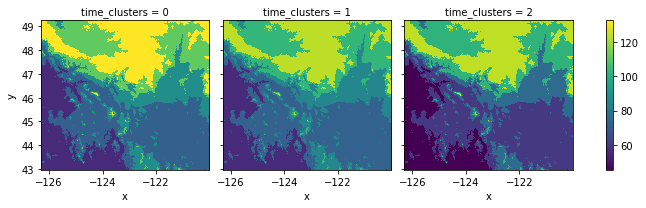

In [22]:
space_means = means[:, space_clusters].unstack('space')
space_means.plot.imshow(x='x', y='y', col='time_clusters')

## K-means refinement

### Overview

We have seen how co-clustering allows one to reorder the rows and columns of a two-dimensional data set such that its elements are sorted in 'blocks'. In this picture, the co-clusters can be identified as the squares in the checkerboard structure. An optional subsequent step consists in performing a standard clustering analysis, such as k-means, to identify similarity patterns across the co-clusters, in such a way that similar squares in the checkerboard can be joined in the same cluster. For the data set considered here, performing such refinement step can be seen as a way to identify sub-regions with similar spring index values across different year spans.

CGC implements this refinement step using [k-means](https://en.wikipedia.org/wiki/K-means_clustering).
The following features are computed for each of the co-clusters and used to perform the refinement clustering analysis:

* mean value;

* standard deviation;

* minimum value;

* maximum value;

* 5% quantile;

* 95% quantile.

The refinement clustering analysis is run for multiple k's, and the optimal value selected as the smallest value for which the sum or centroid variances is below a given threshold. In addition to the information on the previous co-clustering analysis, one needs to specify the range of k values for the search of optimal values when initializing the `Kmeans` object:

In [23]:
km = Kmeans(
    spring_index.data,
    row_clusters=results.row_clusters,
    col_clusters=results.col_clusters,
    n_row_clusters=num_time_clusters,
    n_col_clusters=num_space_clusters,
    k_range=range(2, 15), 
    kmean_max_iter=100,  # max k-means iteration for each k value
    var_thres=1.  # threshold for the sum of centroid variances
)

The refinement analysis is then run as:

In [24]:
results_kmeans = km.compute()

Visualizing the variance trend as a function of k allows to verify whether the choice of the threshold is properly set (the optimal k value should be approximately equal to [the "elbow" of the curve](https://en.wikipedia.org/wiki/Elbow_method_(clustering))):

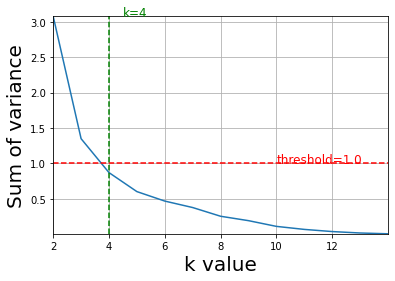

In [25]:
km.plot_elbow_curve()

### Results

The object returned by `Kmeans.compute` contains all results, most importantly the optimal `k` value and the centroids of the co-clusters' means:

In [26]:
print(f"Optimal k value: {results_kmeans.k_value}")
print(f"Centroids of co-clusters' means: {results_kmeans.cl_mean_centroids}")

Optimal k value: 4
Centroids of co-clusters' means: [[127.18341573  58.06659088  84.71422768  84.71422768 100.29519145]
 [127.18341573  58.06659088  58.06659088 100.29519145 100.29519145]
 [127.18341573  58.06659088  58.06659088  84.71422768  84.71422768]]


The centroids can be employed to plot the refined cluster averages of the spring index:

In [27]:
means.data = results_kmeans.cl_mean_centroids

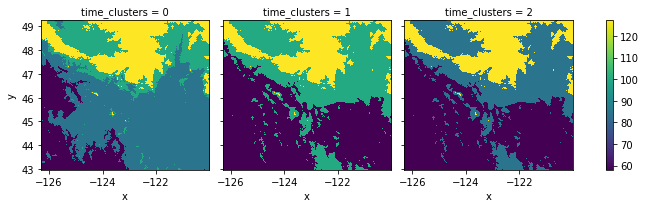

In [28]:
space_means_refined = means[:, space_clusters].unstack('space')
space_means_refined.plot.imshow(x='x', y='y', col='time_clusters')